In [1]:
import cdsapi

client = cdsapi.Client(url='https://cds-beta.climate.copernicus.eu/api', key='6db1903d-4754-4084-a35e-fd1d44e2f457')

## Access Temperature variable from ADS/CDS

## Access relative humidity

In [2]:
# dataset = "reanalysis-era5-pressure-levels"
# request = {
#     'product_type': ['reanalysis'],
#     'variable': ['relative_humidity', 'specific_cloud_liquid_water_content', 'specific_rain_water_content', 'temperature'],
#     'year': ['2020'],
#     'month': ['08'],
#     'day': ['03'],
#     'time': ['14:00'],
#     'data_format': 'netcdf',
#     'download_format': 'unarchived'
# }

# client.retrieve(dataset, request, 'download.nc')

## ERA5-Land monthly averaged data from 1950 to present 
https://cds-beta.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means?tab=overview

### Focus in Madagascar 
```'area': [-9.95, 40.23, -26.8, 52.45]```

In [3]:
dataset = "reanalysis-era5-land-monthly-means"
request = {
    'product_type': ['monthly_averaged_reanalysis'],
    'variable': ['2m_temperature', 'skin_temperature', 'soil_temperature_level_1', 'soil_temperature_level_2', 'soil_temperature_level_3', 'soil_temperature_level_4', 
                 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4',
                 'potential_evaporation', 'runoff','sub_surface_runoff', 'surface_runoff', 'total_evaporation',
                 '10m_u_component_of_wind', '10m_v_component_of_wind',
                 'total_precipitation', 'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation'],
    'year': [str(x) for x in range(1991, 2024)],
                 # ['2018', '2019', '2020', '2021', '2022', '2023'],
    'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
    'time': ['00:00'],
    'data_format': 'netcdf',
    'download_format': 'unarchived',
    'area': [-9.95, 40.23, -26.8, 52.45]
}

# client.retrieve(dataset, request, 'era5-land-monthly-means-madagascar-2018-2024.nc')
client.retrieve(dataset, request).download()

2024-09-09 08:00:12,764 INFO Request ID is d5888c44-909a-4a9a-a545-44f367af60d0
2024-09-09 08:00:12,785 INFO status has been updated to accepted
2024-09-09 08:00:44,066 INFO status has been updated to running
2024-09-09 08:22:30,670 WARNING Structural differences in grib fields detected, safely opening as a list of datasets. This may result in multiple files being created.
2024-09-09 08:22:30,672 INFO Creating download object as zip with files:
['data_0.nc', 'data_1.nc', 'data_2.nc', 'data_3.nc']
2024-09-09 08:22:30,672 INFO status has been updated to successful


da49a9872b4d4b3977bccb19db6e50c7.zip:   0%|          | 0.00/113M [00:00<?, ?B/s]

'da49a9872b4d4b3977bccb19db6e50c7.zip'

In [4]:
!unzip -o ba855dda853e457af1754a3c905632f.zip

Archive:  ba855dda853e457af1754a3c905632f.zip
  inflating: data_0.nc               
  inflating: data_1.nc               
  inflating: data_2.nc               
  inflating: data_3.nc               


In [5]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import numpy as np
import dask

In [6]:
plot_params = {
    '2m_temperature': {
        'short_name': 't2m_c',
        'cmap': 'RdBu_r',
        'abs_diff_cmap': 'RdBu_r',
        'plot_title': '2m Temperature [C]',
        'description': 'This parameter is the temperature of air at 2m above the surface of land, sea or in-land waters. \
        2m temperature is calculated by interpolating between the lowest model level and the Earth\'s surface, taking account of the atmospheric conditions.'
    },
    
    'skin_temperature': {
        'short_name': 'skt_c',
        'cmap': 'RdBu_r',
        'abs_diff_cmap': 'RdBu_r',
        'plot_title': 'Skin temperature [C]',
        'description': 'The skin temperature is the theoretical temperature that is required to satisfy the surface energy balance. \
        It represents the temperature of the uppermost surface layer, which has no heat capacity and so can respond instantaneously to \
        changes in surface fluxes. Skin temperature is calculated differently over land and sea.'
    },
    
    'soil_temperature_level_1': {
        'short_name': 'stl1_c',
        'cmap': 'RdBu_r',
        'abs_diff_cmap': 'RdBu_r',
        'plot_title': 'Soil temperature level 1 (0 - 7cm) [C]',
        'description': 'This parameter is the temperature of the soil at level 1 (in the middle of layer 1). Layer 1: 0 - 7cm'
    },
    
    'soil_temperature_level_2': {
        'short_name': 'stl2_c',
        'cmap': 'RdBu_r',
        'abs_diff_cmap': 'RdBu_r',
        'plot_title': 'Soil temperature level 2 (7 - 28cm) [C]',
        'description': 'This parameter is the temperature of the soil at level 2 (in the middle of layer 1). Layer 1: 7 - 28cm'
    },
    
    'soil_temperature_level_3': {
        'short_name': 'stl3_c',
        'cmap': 'RdBu_r',
        'abs_diff_cmap': 'RdBu_r',
        'plot_title': 'Soil temperature level 3 (28 - 100cm) [C]',
        'description': 'This parameter is the temperature of the soil at level 3 (in the middle of layer 1). Layer 1: 28 - 100cm'
    },
    
    'soil_temperature_level_4': {
        'short_name': 'stl4_c',
        'cmap': 'RdBu_r',
        'abs_diff_cmap': 'RdBu_r',
        'plot_title': 'Soil temperature level 4 (100 - 289cm) [C]',
        'description': 'This parameter is the temperature of the soil at level 4 (in the middle of layer 1). Layer 1: 100 - 289cm'
    },
    
    'volumetric_soil_water_layer_1': {
        'short_name': 'swvl1',
        'cmap': 'Blues',
        'abs_diff_cmap': 'RdBu',
        'plot_title': 'Volumetric soil water layer 1 (0 - 7cm) [m3 m-3]',
        'description': 'This parameter is the volume of water in soil layer 1 (0 - 7cm, the surface is at 0cm). \
        The volumetric soil water is associated with the soil texture (or classification), soil depth, and the underlying groundwater level.'
    },
    
    'volumetric_soil_water_layer_2': {
        'short_name': 'swvl2',
        'cmap': 'Blues',
        'abs_diff_cmap': 'RdBu',
        'plot_title': 'Volumetric soil water layer 2 (7 - 28cm) [m3 m-3]',
        'description': 'This parameter is the volume of water in soil layer 1 (7 - 28cm, the surface is at 0cm). \
        The volumetric soil water is associated with the soil texture (or classification), soil depth, and the underlying groundwater level.'
    },
    
    'volumetric_soil_water_layer_3': {
        'short_name': 'swvl3',
        'cmap': 'Blues',
        'abs_diff_cmap': 'RdBu',
        'plot_title': 'Volumetric soil water layer 3 (28 - 100cm) [m3 m-3]',
        'description': 'This parameter is the volume of water in soil layer 1 (28 - 100cm, the surface is at 0cm). \
        The volumetric soil water is associated with the soil texture (or classification), soil depth, and the underlying groundwater level.'
    },
    
    'volumetric_soil_water_layer_4': {
        'short_name': 'swvl4',
        'cmap': 'Blues',
        'abs_diff_cmap': 'RdBu',
        'plot_title': 'Volumetric soil water layer 4 (100 - 289cm) [m3 m-3]',
        'description': 'This parameter is the volume of water in soil layer 1 (100 - 289cm, the surface is at 0cm). \
        The volumetric soil water is associated with the soil texture (or classification), soil depth, and the underlying groundwater level.'
    },
    
    'potential_evaporation': {
        'short_name': 'pev',
        'cmap': 'YlOrBr',
        'plot_title': 'Potential evaporation [meters]',
        'description': 'This parameter is a measure of the extent to which near-surface atmospheric conditions are \
        conducive to the process of evaporation. It is usually considered to be the amount of evaporation, \
        under existing atmospheric conditions, from a surface of pure water which has the temperature of \
        the lowest layer of the atmosphere and gives an indication of the maximum possible evaporation.'
    },
    
    'runoff': {
        'short_name': 'ro',
        'cmap': 'GnBu',
        'plot_title': 'Runoff [meters]',
        'description': "Some water from rainfall, melting snow, or deep in the soil, stays stored in the soil. \
        Otherwise, the water drains away, either over the surface (surface runoff), \
        or under the ground (sub-surface runoff) and the sum of these two is simply called 'runoff'."
    },
    
    'sub_surface_runoff': {
        'short_name': 'ssro',
        'cmap': 'GnBu',
        'plot_title': 'Sub-Surface Runoff [meters]',
        'description': "Some water from rainfall, melting snow, or deep in the soil, stays stored in the soil. \
        Otherwise, the water drains away, either over the surface (surface runoff), \
        or under the ground (sub-surface runoff) and the sum of these two is simply called 'runoff'."
    },
    
    'surface_runoff': {
        'short_name': 'sro',
        'cmap': 'GnBu',
        'plot_title': 'Surface Runoff [meters]',
        'description': "Some water from rainfall, melting snow, or deep in the soil, stays stored in the soil. \
        Otherwise, the water drains away, either over the surface (surface runoff), \
        or under the ground (sub-surface runoff) and the sum of these two is simply called 'runoff'."
    },
    
    'total_evaporation': {
        'short_name': 'e',
        'cmap': 'YlOrBr',
        'plot_title': 'Evaporation [m of water equivalent]',
        'description': "This parameter is the accumulated amount of water that has evaporated from the Earth's surface, \
        including a simplified representation of transpiration (from vegetation), into vapour in the air above."
    },
    
    '10m_u_component_of_wind': {
        'short_name': 'u10',
        'cmap': 'coolwarm',
        'plot_title': 'U component of wind [m s-1]',
        'description': 'This parameter is the eastward component of the wind. It is the horizontal speed of air moving towards the east, \
        in metres per second. A negative sign thus indicates air movement towards the west. \
        This parameter can be combined with the V component of wind to give the speed and direction of the horizontal wind.'
    },
    
    '10m_v_component_of_wind': {
        'short_name': 'v10',
        'cmap': 'coolwarm',
        'plot_title': 'V component of wind [m s-1]',
        'description': 'This parameter is the northward component of the wind. It is the horizontal speed of air moving towards the north, \
        in metres per second. A negative sign thus indicates air movement towards the south. \
        This parameter can be combined with the U component of wind to give the speed and direction of the horizontal wind.'
    },
    
    'total_precipitation': {
        'short_name': 'tp',
        'cmap': 'PuBuGn',
        'abs_diff_cmap': 'RdBu',
        'plot_title': 'Total precipitation [meters]',
        'description': 'This parameter is the accumulated liquid and frozen water, comprising rain and snow, \
        that falls to the Earth\'s surface. It is the sum of large-scale precipitation and convective precipitation.'
    },
    
    'leaf_area_index_high_vegetation': {
        'short_name': 'lai_hv',
        'cmap': 'Greens',
        'plot_title': 'Leaf area index, high vegetation [m2 m-2]',
        'description': "This parameter is the surface area of one side of all the leaves found over an area of land for \
        vegetation classified as 'high'. This parameter has a value of 0 over bare ground or where there are no leaves. \
        It can be calculated daily from satellite data. It is important for forecasting, for example, \
        how much rainwater will be intercepted by the vegetative canopy, rather than falling to the ground."
    },
    'leaf_area_index_low_vegetation': {
        'short_name': 'lai_lv',
        'cmap': 'Greens',
        'plot_title': 'Leaf area index, low vegetation [m2 m-2]',
        'description': "This parameter is the surface area of one side of all the leaves found over an area of land for \
        vegetation classified as 'low'. This parameter has a value of 0 over bare ground or where there are no leaves. \
        It can be calculated daily from satellite data. It is important for forecasting, for example, \
        how much rainwater will be intercepted by the vegetative canopy, rather than falling to the ground."
    },
}

In [7]:
ds = xr.open_mfdataset(['data_0.nc', 'data_1.nc', 'data_2.nc', 'data_3.nc'], chunks={'time': "auto"}, concat_dim="valid_time", combine='nested', parallel=False)
# Resample to monthly data (if necessary)
ds_sorted = ds.sortby('valid_time')
ds_monthly = ds_sorted.resample(valid_time='1ME').first()
ds_monthly['t2m_c'] = ds_monthly['t2m'] - 273.15
ds_monthly['skt_c'] = ds_monthly['skt'] - 273.15
ds_monthly['stl1_c'] = ds_monthly['stl1'] - 273.15
ds_monthly['stl2_c'] = ds_monthly['stl2'] - 273.15
ds_monthly['stl3_c'] = ds_monthly['stl3'] - 273.15
ds_monthly['stl4_c'] = ds_monthly['stl4'] - 273.15

/home/george/drought-311-venv/lib64/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/george/drought-311-venv/lib64/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/george/drought-311-venv/lib64/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/george/drought-311-venv/lib64/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/george/drought-311-venv/lib64/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/george/drought-311-venv/lib64/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by fac

In [8]:
ds_monthly

<xarray.Dataset> Size: 856MB
Dimensions:     (valid_time: 396, latitude: 169, longitude: 123)
Coordinates:
    number      int64 8B 0
  * latitude    (latitude) float64 1kB -10.0 -10.1 -10.2 ... -26.6 -26.7 -26.8
  * longitude   (longitude) float64 984B 40.23 40.33 40.43 ... 52.23 52.33 52.43
  * valid_time  (valid_time) datetime64[ns] 3kB 1991-01-31 ... 2023-12-31
Data variables: (12/26)
    swvl1       (valid_time, latitude, longitude) float32 33MB dask.array<chunksize=(1, 22, 16), meta=np.ndarray>
    swvl2       (valid_time, latitude, longitude) float32 33MB dask.array<chunksize=(1, 22, 16), meta=np.ndarray>
    swvl3       (valid_time, latitude, longitude) float32 33MB dask.array<chunksize=(1, 22, 16), meta=np.ndarray>
    swvl4       (valid_time, latitude, longitude) float32 33MB dask.array<chunksize=(1, 22, 16), meta=np.ndarray>
    stl1        (valid_time, latitude, longitude) float32 33MB dask.array<chunksize=(1, 22, 16), meta=np.ndarray>
    stl2        (valid_time, latitude, longitude) float32 33MB dask.array<chunksize=(1, 22, 16), meta=np.ndarray>
    ...          ...
    t2m_c       (valid_time, latitude, longitude) float32 33MB dask.array<chunksize=(1, 22, 16), meta=np.ndarray>
    skt_c       (valid_time, latitude, longitude) float32 33MB dask.array<chunksize=(1, 22, 16), meta=np.ndarray>
    stl1_c      (valid_time, latitude, longitude) float32 33MB dask.array<chunksize=(1, 22, 16), meta=np.ndarray>
    stl2_c      (valid_time, latitude, longitude) float32 33MB dask.array<chunksize=(1, 22, 16), meta=np.ndarray>
    stl3_c      (valid_time, latitude, longitude) float32 33MB dask.array<chunksize=(1, 22, 16), meta=np.ndarray>
    stl4_c      (valid_time, latitude, longitude) float32 33MB dask.array<chunksize=(1, 22, 16), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [9]:
def visualise_variable_annually(variable_name, year):
    
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
    months = ["January", "February", "March", "April", "May", "June","July", "August", "September", "October", "November", "December"]
    for i, ax in enumerate(axes.flatten()):
        (ds_monthly[plot_params[variable_name]["short_name"]].sel(valid_time=f'{year}-{i + 1:02d}', method='nearest')).plot(ax=ax, transform=ccrs.PlateCarree(),cmap=plot_params[variable_name]['cmap'], cbar_kwargs={'label': plot_params[variable_name]["plot_title"]})
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.set_title(f'{plot_params[variable_name]["plot_title"]} for {months[i]} {year}')
    fig.tight_layout()
    plt.show()

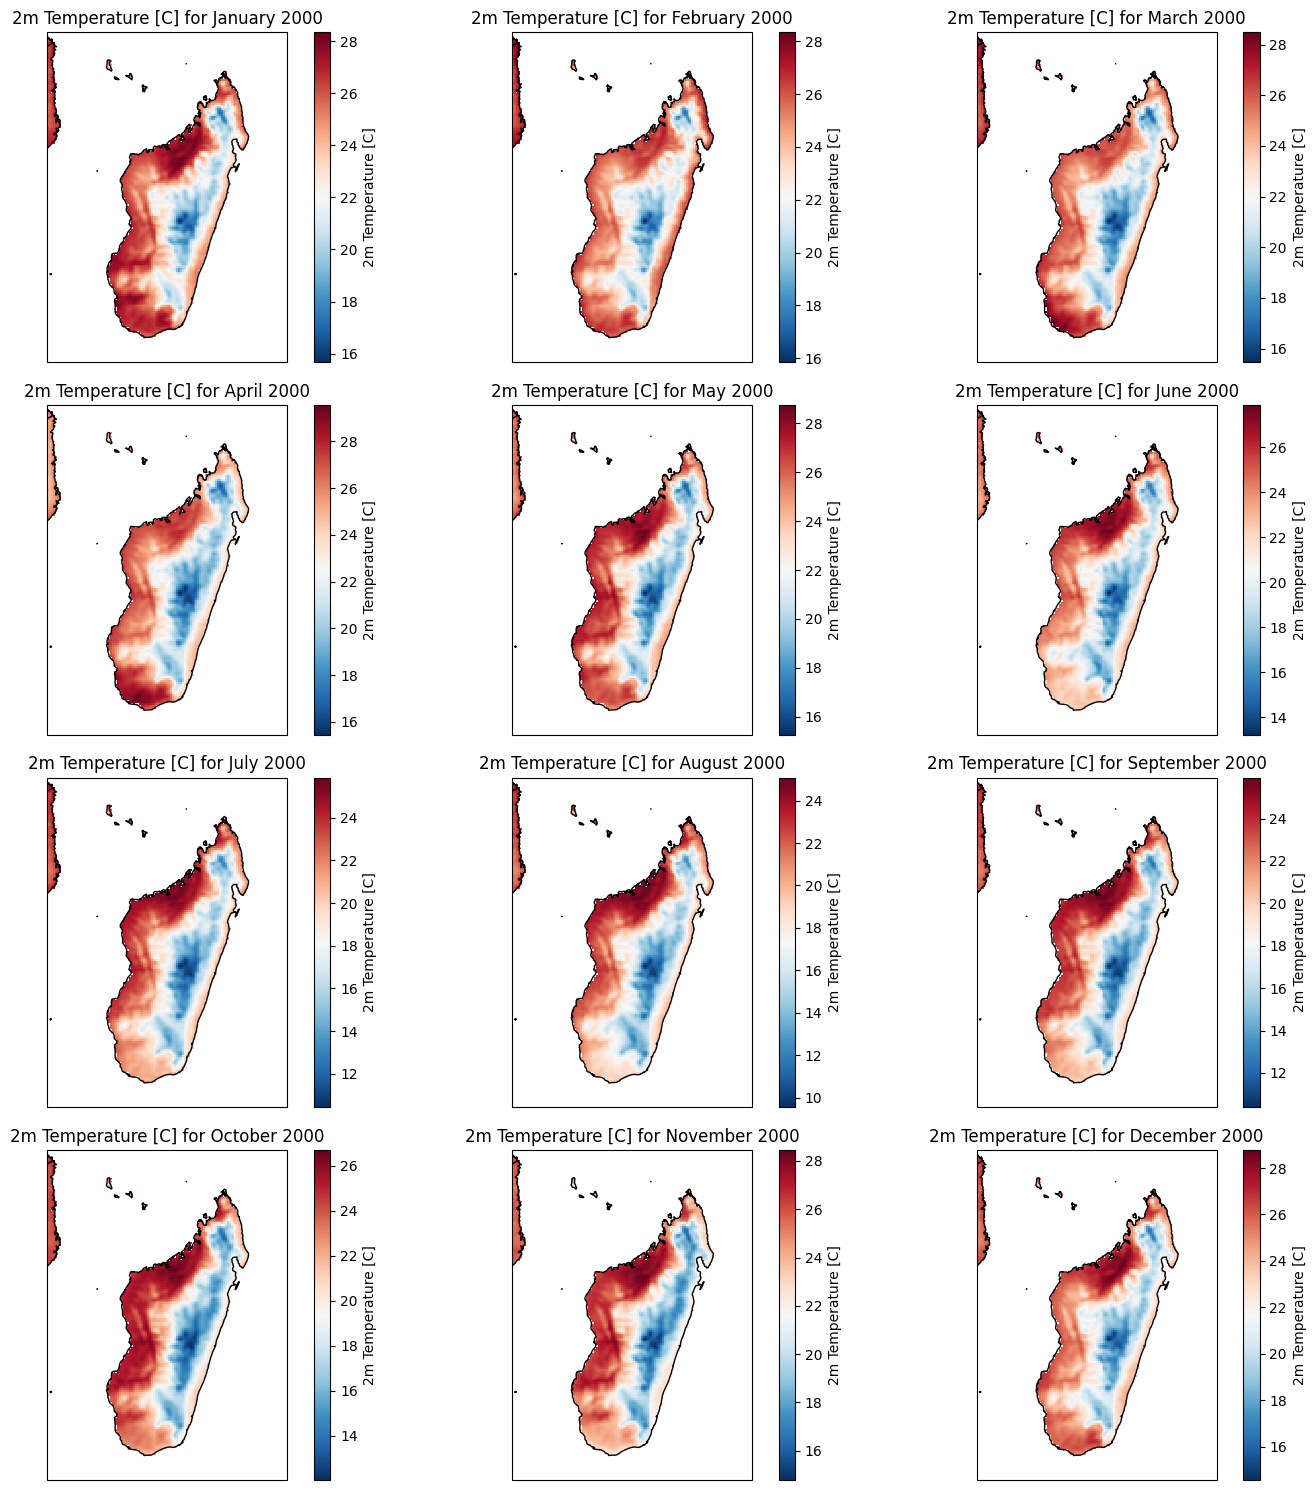

In [10]:
visualise_variable_annually('2m_temperature', 2000)

## Compare to baseline (1991 to 2023)

In [11]:
def create_monthly_baseline(ds_monthly, ignore_years=[2020]):
    ds_baseline = ds_monthly.sel(valid_time=~ds_monthly['valid_time'].dt.year.isin(ignore_years))
    monthly_baseline = ds_baseline.groupby('valid_time.month').mean(dim='valid_time')
    return monthly_baseline

In [12]:
def make_comparisons(ds_annual, ds_monthly_baseline, variable_name, year, show_diff_plots=True, show_box_plots=True, show_hists=True, show_extremes_plot=True, extreme_perc=5):
    ds_annual_variable = ds_annual[plot_params[variable_name]["short_name"]]
    ds_monthly_variable = ds_annual_variable.groupby('valid_time.month').mean(dim='valid_time')

    ds_monthly_baseline_variable = ds_monthly_baseline[plot_params[variable_name]["short_name"]]

    print('Selected variable....')
    months = ["January", "February", "March", "April", "May", "June",
              "July", "August", "September", "October", "November", "December"]

    # Create subplots
    if show_diff_plots:
        fig_plot, axes_plot = plt.subplots(nrows=4, ncols=3, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
        fig_plot.suptitle(f'Comparisons for {variable_name} in {year}', fontsize=16)
    
    # Box Plots in a 3x4 layout
    if show_box_plots:
        fig_box, axes_box = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
        fig_box.suptitle(f'{variable_name} Box Plot Comparisons for {year}', fontsize=16)

    # Histogram Plots in a 3x4 layout
    if show_hists:
        fig_hist, axes_hist = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
        fig_hist.suptitle(f'{variable_name} Histogram Comparisons for {year}', fontsize=16)

    if show_extremes_plot:
        # Focus on Extremes in a 3x4 layout
        fig_extremes, axes_extremes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
        fig_extremes.suptitle(f'{variable_name} Focus on Extremes for {year}', fontsize=16)


    for i in range(12):
        print(f'Processing month {months[i]}')
        month = i + 1
        
        # Extract the data for the current month
        annual_month = ds_monthly_variable.sel(month=month)
        baseline_month = ds_monthly_baseline_variable.sel(month=month)

        if show_diff_plots:
            # Absolute Difference Map
            abs_diff = annual_month - baseline_month
            ax_plot = axes_plot.flatten()[i]
            abs_diff.plot(ax=ax_plot, transform=ccrs.PlateCarree(), cmap=plot_params[variable_name]["abs_diff_cmap"], center=0, cbar_kwargs={'label': f'Abs Diff {variable_name} ({months[i]})'})
            ax_plot.coastlines()
            ax_plot.add_feature(cfeature.BORDERS)
            ax_plot.set_title(f'Abs Diff {months[i]} {year}')

        
        # Ensure only valid pixels are compared (non-NaN in both datasets)
        if show_box_plots or show_hists or show_extremes_plot:
            annual_month_flat = annual_month.to_numpy().flatten()
            baseline_month_flat = baseline_month.to_numpy().flatten()
    
            valid_data = ~np.isnan(annual_month_flat) & ~np.isnan(baseline_month_flat)
    
            annual_month_valid = annual_month_flat[valid_data]
            baseline_month_valid = baseline_month_flat[valid_data]
        
        # Focus on Extremes Plot
        if show_extremes_plot:
            ax_extremes = axes_extremes.flatten()[i]
            top_2_percent_threshold = np.percentile(baseline_month_valid, 100-extreme_perc)
            bottom_2_percent_threshold = np.percentile(baseline_month_valid, extreme_perc)
    
            # Identify the top and bottom 2% pixels
            high_baseline = baseline_month_valid[baseline_month_valid >= top_2_percent_threshold]
            high_annual = annual_month_valid[baseline_month_valid >= top_2_percent_threshold]
    
            low_baseline = baseline_month_valid[baseline_month_valid <= bottom_2_percent_threshold]
            low_annual = annual_month_valid[baseline_month_valid <= bottom_2_percent_threshold]
    
            # Scatter plot for the high 2%
            ax_extremes.scatter(high_baseline, high_annual, color='red', label=f'High {extreme_perc}%')
            ax_extremes.plot([min(high_baseline), max(high_baseline)],
                             [min(high_baseline), max(high_baseline)], 'k--')
    
            # Scatter plot for the low 2%
            ax_extremes.scatter(low_baseline, low_annual, color='blue', label=f'Low {extreme_perc}%')
            ax_extremes.plot([min(low_baseline), max(low_baseline)],
                             [min(low_baseline), max(low_baseline)], 'k--')
    
            ax_extremes.set_xlabel('Baseline')
            ax_extremes.set_ylabel(f'{year}')
            ax_extremes.set_title(f'{months[i]}')
            ax_extremes.grid(True)
            ax_extremes.legend()
        
        # Box Plot
        if show_box_plots:
            ax_box = axes_box.flatten()[i]
            ax_box.boxplot([baseline_month_valid, annual_month_valid], tick_labels=[f'Baseline', f'{months[i]} {year}'], notch=True)
            ax_box.set_title(f'{months[i]}')
            ax_box.grid(True)

        # Histogram Plot
        if show_hists:
            ax_hist = axes_hist.flatten()[i]
            ax_hist.hist(baseline_month_valid, bins=30, alpha=0.5, label='Baseline', color='blue')
            ax_hist.hist(annual_month_valid, bins=30, alpha=0.5, label=months[i], color='red')
            ax_hist.set_title(f'{months[i]}')
            ax_hist.legend(loc='upper right')

    if show_diff_plots:
        fig_plot.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    if show_box_plots:
        fig_box.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    if show_hists:
        fig_hist.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    if show_extremes_plot:
        fig_extremes.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

In [13]:
target_year = 2017
monthly_baseline = create_monthly_baseline(ds_monthly, ignore_years=[2017, 2018, 2019, 2020, 2021, 2022, 2023])
ds_target = ds_monthly.sel(valid_time=ds_monthly['valid_time'].dt.year == target_year)

Selected variable....
Processing month January
Processing month February
Processing month March
Processing month April
Processing month May
Processing month June
Processing month July
Processing month August
Processing month September
Processing month October
Processing month November
Processing month December


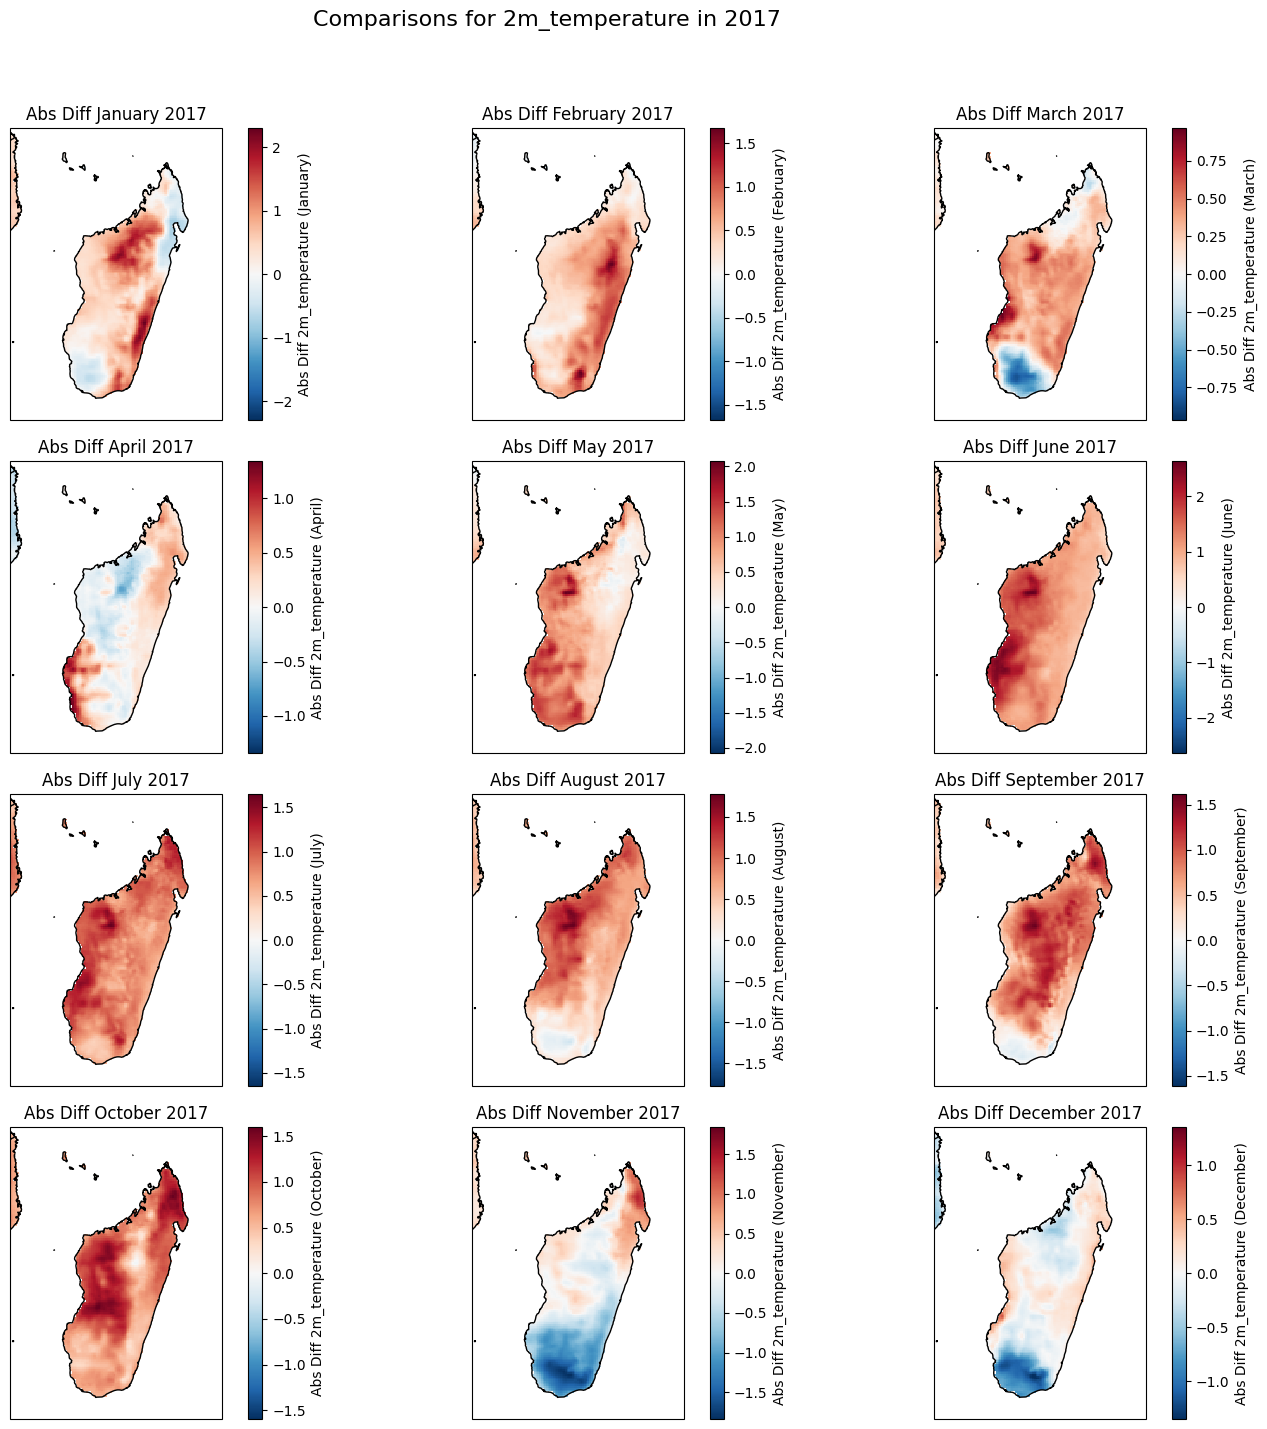

In [14]:
make_comparisons(ds_target, monthly_baseline, '2m_temperature', target_year, show_box_plots=False, show_hists=False, show_extremes_plot=False)

Selected variable....
Processing month January
Processing month February
Processing month March
Processing month April
Processing month May
Processing month June
Processing month July
Processing month August
Processing month September
Processing month October
Processing month November
Processing month December


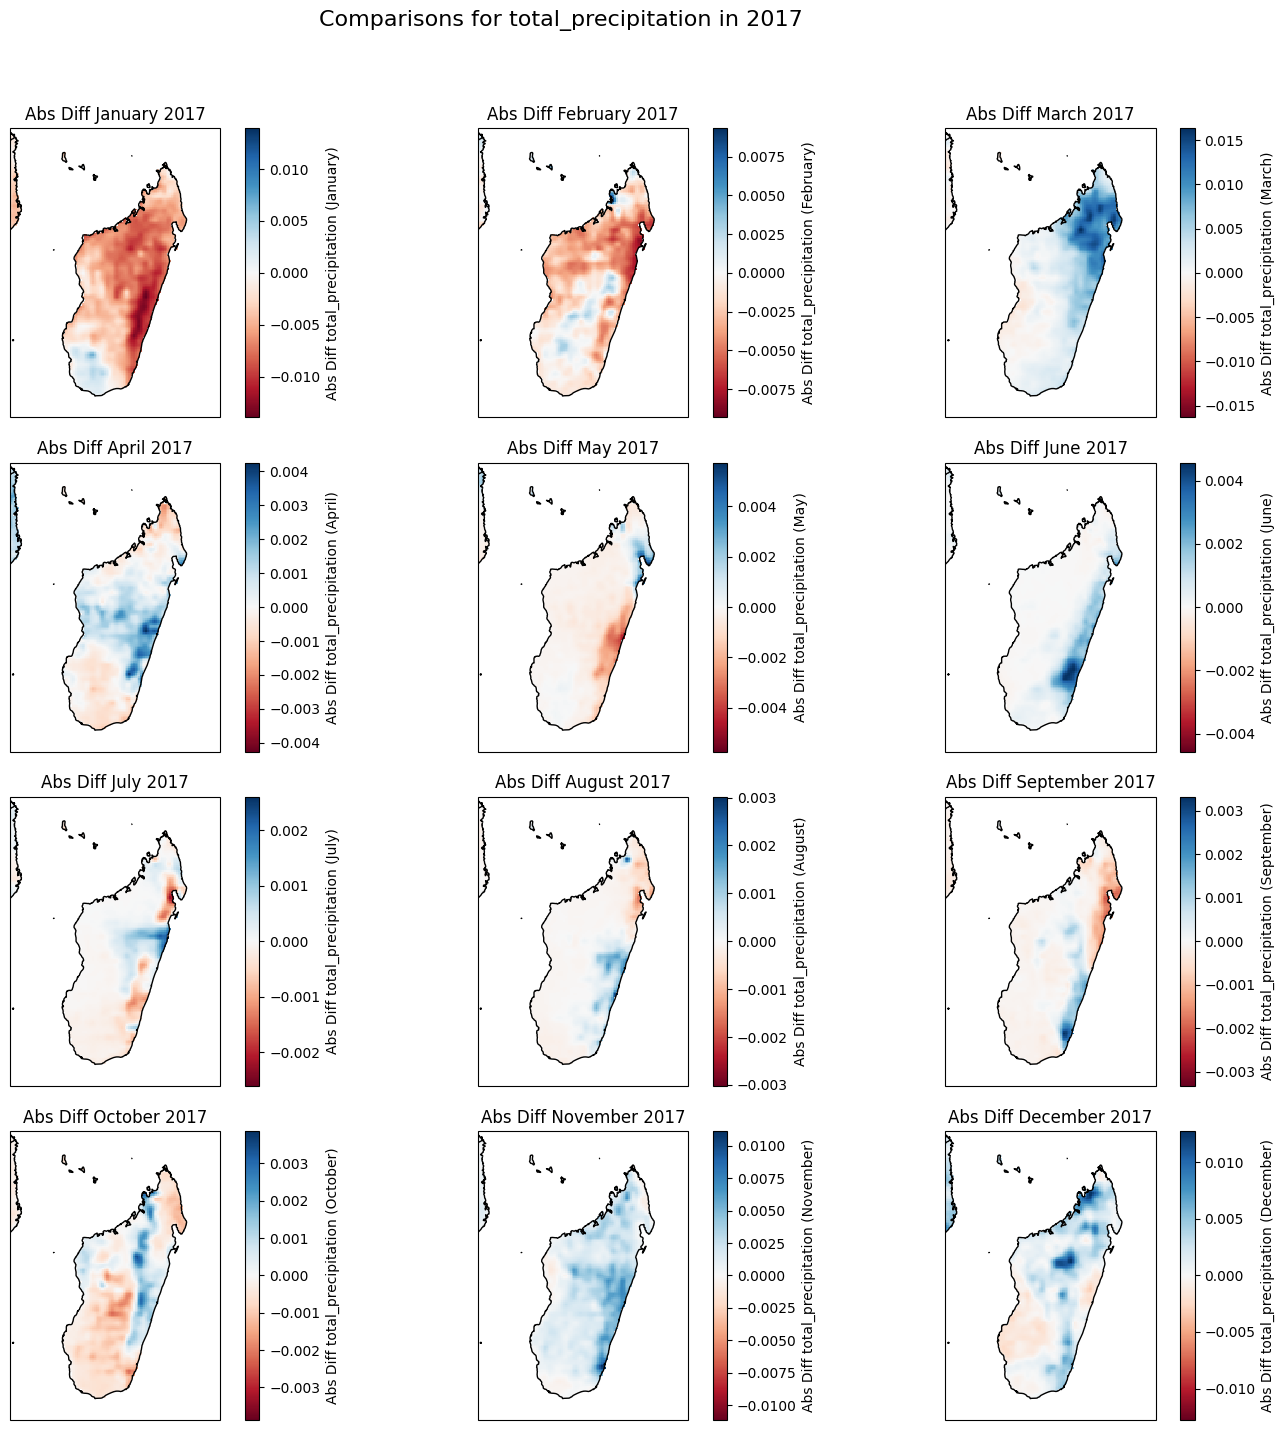

In [15]:
make_comparisons(ds_target, monthly_baseline, 'total_precipitation', target_year, show_box_plots=False, show_hists=False, show_extremes_plot=False)

### Temperature and precipitation gridded data for global and regional domains derived from in-situ and satellite observations

https://cds-beta.climate.copernicus.eu/datasets/insitu-gridded-observations-global-and-regional?tab=download

In [16]:
dataset = "insitu-gridded-observations-global-and-regional"
request = {
    'origin': 'chirps',
    'region': 'africa',
    'variable': ['precipitation'],
    'time_aggregation': 'daily',
    'horizontal_aggregation': ['0_25_x_0_25'],
    'year': ['2019', '2020', '2021'],
    'version': ['v2_0']
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

Exception: Missing/incomplete configuration file: /home/george/.cdsapirc

In [ ]:
dataset = "insitu-gridded-observations-global-and-regional"
request = {
    'origin': 'gpcc',
    'region': 'global',
    'variable': ['precipitation'],
    'time_aggregation': 'monthly',
    'horizontal_aggregation': ['1_x_1'],
    'year': ['2019', '2020', '2021'],
    'version': ['v2020_0']
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

### River discharge and related historical data from the Global Flood Awareness System  
https://cds-beta.climate.copernicus.eu/datasets/cems-glofas-historical?tab=download

In [ ]:
dataset = "cems-glofas-historical"
request = {
    'system_version': ['version_4_0'],
    'hydrological_model': ['lisflood'],
    'product_type': ['consolidated'],
    'variable': ['river_discharge_in_the_last_24_hours', 'runoff_water_equivalent', 'soil_wetness_index'],
    'hyear': ['2018', '2019', '2020', '2021', '2022', '2023'],
    'hmonth': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
    'hday': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'],
    'data_format': 'netcdf',
    'download_format': 'zip',
    'area': [-11, 43, -26, 51]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()